<img src="img/ENSAE_logo.jpg">

# *ELTDM Project*
# *Parallelised Community Detection with Spark MapReduce*  
**Mastère Spécialisé Data Science, 2018-19, "Éléments logiciels pour le traitement des données massives"** 
  
**Alban CHAMPEVILLE DE BOISJOLLY**   
**Yosuke IJIRI**  
  

# Abstract

This project implements a parallelised community detection algorithm proposed by [*"S. Moon, et al., Parallel community detection on large graphs with MapReduce and GraphChi, Data Knowl. Eng. (2015)"*.](http://dx.doi.org/10.1016/j.datak.2015.05.001) The model is based on Girvan-Newman Algorithm. We use Python, Spark and AWS as the environment.

# 1. Introduction

Analysing network datum has become a key issue in many areas to base suggestions, advices and strategies in many sectors and applications. Community detection aims at identifying clusters in a network, i.e. regroup vertices into groups of high density connected vertices i.a. to make friends recommendations or target marketing. The Girvan-Newman algorithm is one of the most used for this objective. It uses the concept of edge betweenness, which is a measure of the centrality and influence of an edge in a network, with the shortest-path method.

Given the size of networks and the method used to compute the edge betweenness, parallelization of the computation is unavoidable to realize the task efficiently. Our work is focused on the Shortest-Path Betweeness MapReduce Algorithm (SPB-MRA). Parallelizing computations will be realized at each of the 4 stages of the Map-Reduce algorithm.

Related article:  " Parallel community detection on large graphs with MapReduce and GraphChi" published in 2015 by Seunghyeon Moon, Jae-Gil Lee, Minseo Kang, Minsoo Choy and Jin-woo Lee.

# 2. Model

Community Detection, Modularity Method

# 3. Algorithm

Girvan-Newman Algorithm

<img src="img/algo.png" width="400" align="left">

# 4. Data

Stanford Large Network Dataset Collection (https://snap.stanford.edu/data/)

# 5. Environment

Python + Spark + AWS

# 6. Implementation

Here is the code:

In [1]:
import numpy as np
import pandas as pd

In [2]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [3]:
import os
os.getcwd()

'/Users/IjiriYosuke/Documents/GitHub/ELTDM-Project'

In [103]:
# Read the data
#data = np.loadtxt("./Data/ca-GrQc_small.txt", dtype='uint16')
data = np.loadtxt("./Data/test2.txt", dtype='uint16')
print(data)
print(type(data))
#data_ = pd.DataFrame(data)
#data_.to_csv("./Data/test_.txt", sep="/t", header=None, index=False)
#np.savetxt("./Data/test_.txt", data, fmt="%.0f", delimiter = "\t")

[[1 2]
 [1 3]
 [2 3]
 [4 3]
 [3 5]
 [5 6]
 [5 7]
 [1 8]
 [8 3]
 [6 8]]
<class 'numpy.ndarray'>


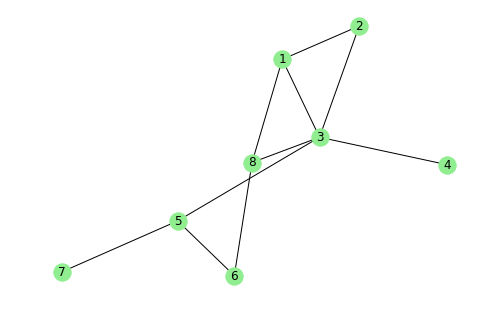

In [112]:
#Visualisation of the graph
import pandas
import networkx as nx
import matplotlib.pyplot as plt

nodes = set([n1 for n1, n2 in data] + [n2 for n1, n2 in data])
nsize=300

import time
def draw_graph(graph):
    # extract nodes from graph
    #nodes = set([n1 for n1, n2 in graph] + [n2 for n1, n2 in graph])
    # create networkx graph
    G=nx.Graph()
    # add nodes
    for node in nodes:
        G.add_node(node)
    # add edges
    for edge in graph:
        G.add_edge(edge[0], edge[1])
    # draw graph
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels = True, node_size=nsize, node_color="lightgreen")
    # show graph
    t = float(time.time())
    plt.savefig('./Data/Figures/Pre_Round1.png')
    plt.show()

draw_graph(data)

In [105]:
nodeId = np.unique(data)
nrow = len(data)
print("The data contains")
print(len(nodeId), "nodes, and", nrow, "edges (including duplicates)")

The data contains
8 nodes, and 10 edges (including duplicates)


In [113]:
# Make a list of adjacency lists (first element is the node of origin)
adj_list = []
for n in nodeId:
    adj = []
    for i in range(nrow):
        if data[i, 0] == n:
            adj.append(data[i, 1])
        if data[i, 1] == n:
            adj.append(data[i, 0])
    adj = list(set(adj)) 
    adj.insert(0, n)
    adj_list.append(adj)
#print(adj_list)

In [107]:
# Make tuple for each node
class tuples():
    def __init__(self, targetId, sourceId, distance, status, weight, pathInfo, adjList) :
        self.targetId = targetId
        self.sourceId = sourceId
        self.distance = distance
        self.status = status
        self.weight = weight
        self.pathInfo = pathInfo
        self.adjList = adjList

network = []
for n in nodeId:
    v = tuples(targetId = n, sourceId = n, distance = 0, status = 'a', weight = 1, pathInfo = [], adjList = [])
    for i in range(len(adj_list)):
        if adj_list[i][0] == n:
            v.adjList = adj_list[i][1:len(adj_list[i])]
            break
    network.append([v.targetId, v.sourceId, v.distance, v.status, v.weight, v.pathInfo, v.adjList])
#for i in range(len(network)):
#    print(network[i])

# Parallelisation part

In [10]:
#sc.stop()
from copy import deepcopy  # For making a deep copy of tuple
from itertools import groupby
from pyspark import SparkContext, SparkConf
conf = (SparkConf()
        .setMaster("local[*]")
        .setAppName("Test Name")
        .set('spark.executor.memory', '14g')
        .set('spark.driver.memory', '14g'))
sc = SparkContext(conf = conf)
#SparkConf().set('spark.driver.memory', '14g')
#SparkConf().set('spark.executor.memory', '14g')
#SparkConf().set('spark.app.name', 'test')
#sc = SparkContext(conf=SparkConf())
sc

<SparkContext master=local[*] appName=Test Name>

In [11]:
sc._conf.getAll()

[('spark.executor.memory', '14g'),
 ('spark.app.name', 'Test Name'),
 ('spark.rdd.compress', 'True'),
 ('spark.driver.host', '10.21.1.74'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.driver.port', '57508'),
 ('spark.driver.memory', '14g'),
 ('spark.app.id', 'local-1544926989773'),
 ('spark.ui.showConsoleProgress', 'true')]

In [114]:
# Set a dataset and create key-value pairs
rdd = sc.parallelize(network)
rdd = rdd.map(lambda x: (x[0], x[1:]))
output = rdd.collect()

# < Stage 1 - Map >

In [109]:
def stage1_map(p):  
    result = []
    if p[1][2] == 'a':
        p[1][2] = 'i'
        p[1][1] += 1
        p[1][4].append(p[0])
        x = deepcopy(p)
        result.append(x)
        temp = p[1][5].copy()
        for i in range(len(temp)):
            k = temp[i]
            p[1][2] = 'a'
            p[1][5] = []
            y = deepcopy(p)
            result.append((k, y[1]))
        return result
    else:
        els = deepcopy(p)
        result.append(els)
        return result
'''
pos_map1 = rdd.flatMap(stage1_map)
pos_map1.collect()
'''
# Add artifitial records in order to test MapReduce functions
#for_testing = pos_map1.collect()
#add_for_testing = [(4, [4, 2, 'a', 1, [2], []]), 
#    (4, [2, 1, 'a', 1, [3], [1, 3]]),
#    (4, [2, 2, 'a', 1, [2], []]),
#    (4, [2, 5, 'a', 1, [2], []]),
#    (4, [2, 1, 'a', 1, [3], [1, 3]]),
#    (4, [2, 1, 'a', 1, [5], [5]]),
#    (4, [2, 1, 'a', 1, [2], [2]])]
#for_testing.extend(add_for_testing)
#
#for i in range(len(for_testing)):
#    print(for_testing[i])
#pos_map1_test = sc.parallelize(for_testing)

'\npos_map1 = rdd.flatMap(stage1_map)\npos_map1.collect()\n'

# < Stage 1 - Reduce >

This part consists of 6 steps:  
1) Add *sourceId* to key  
2) Aggregate the values that belong to the same key  
3) Take only values that have the shortest distance in the same key  
4) Replace *weight* of such values $\in minList$ with the size of $minList$  
5) Flatten values and list the tuples  
6) Fill in any empty adjList

In [14]:
#pos_map1.collect()
#pos_map1_test.collect()
'''
red1_twokeys = pos_map1.map(lambda x: ((x[0],x[1][0]), x[1][1:]))
'''
#red1_twokeys = pos_map1_test.map(lambda x: ((x[0],x[1][0]), x[1][1:]))
#red1_twokeys.collect()

'\nred1_twokeys = pos_map1.map(lambda x: ((x[0],x[1][0]), x[1][1:]))\n'

In [15]:
def join(x, y):
    # 4 conditional statements below to join values
    # with correct level of nesting
    if (type(x[0]) is list) and (type(y[0]) is not list):
        return x+[y]
    elif (type(x[0]) is not list) and (type(y[0]) is list):
        return [x]+y
    elif (type(x[0]) is not list) and (type(y[0]) is not list):
        return [x]+[y]
    else:
        return x+y
    isinstance(x[0], int)
'''
red1_grouped = red1_twokeys.reduceByKey(join)
#red1_twokeys.reduceByKey(join).collect()
'''

'\nred1_grouped = red1_twokeys.reduceByKey(join)\n#red1_twokeys.reduceByKey(join).collect()\n'

In [16]:
def stage1_reduce(x):
    if type(x[1][0]) is list:
        m = x[1][0][0]
        for s in range(len(x[1])):
            if x[1][s][0] < m:
                m = x[1][s][0]
        minList = []
        # Drop tuple(s) with non-shortest distance
        for s in range(len(x[1])):
            if x[1][s][0] == m:
                minList.append(x[1][s])
        y = (x[0], minList)
        # Update weight
        for s in range(len(minList)):
            y[1][s][2] = len(minList)
        return y
    else:
        return x
'''
red1_weighted = red1_grouped.map(stage1_reduce)
#red1_grouped.map(stage1_reduce).collect()
'''

'\nred1_weighted = red1_grouped.map(stage1_reduce)\n#red1_grouped.map(stage1_reduce).collect()\n'

In [17]:
def twokeys_to_onekey(x):
    k = x[0][0]
    v = [x[0][1]]
    v.extend(x[1])
    return k, v
'''
# From two-keys tuples to one-key tuples
record = red1_weighted.map(twokeys_to_onekey).collect()

# To flatten the grouped values (non-parallelized)
new = []
for i in range(len(record)):
    if type(record[i][1][1]) is list:
        record[i]
        key = record[i][0]
        srcId = [record[i][1][0]]
        others = record[i][1][1:]
        for j in range(len(others)):
            s = srcId.copy()
            o = others[j]
            s.extend(o)
            newrec = (key, s)
            new.append(newrec)
pos_red1 = list(filter(lambda item: type(item[1][1]) != list, record))  
pos_red1.extend(new)
for i in range(len(pos_red1)):
    print(pos_red1[i])
output = pos_red1.copy()
'''

'\n# From two-keys tuples to one-key tuples\nrecord = red1_weighted.map(twokeys_to_onekey).collect()\n\n# To flatten the grouped values (non-parallelized)\nnew = []\nfor i in range(len(record)):\n    if type(record[i][1][1]) is list:\n        record[i]\n        key = record[i][0]\n        srcId = [record[i][1][0]]\n        others = record[i][1][1:]\n        for j in range(len(others)):\n            s = srcId.copy()\n            o = others[j]\n            s.extend(o)\n            newrec = (key, s)\n            new.append(newrec)\npos_red1 = list(filter(lambda item: type(item[1][1]) != list, record))  \npos_red1.extend(new)\nfor i in range(len(pos_red1)):\n    print(pos_red1[i])\noutput = pos_red1.copy()\n'

# < Stage2 - Map & Reduce>

In [18]:
from operator import add
def stage2_map(x):
    edges_on_the_path = []
    for i in range(len(x[1][4])-1):
        k = (x[1][4][i], x[1][4][i+1])
        w = x[1][3]
        edges_on_the_path.append((k, 1/w))
    return edges_on_the_path

# < Stage3 - Map & Reduce >

# < Stage4 - Map >

In [19]:
def stage4_map(x):
    counter = 0
    output = []
    for i in range(len(distributed_cache)):
        if x[0] in distributed_cache[i][0]:
            counter += 1
            c = distributed_cache[i][0][not(distributed_cache[i][0].index(x[0]))]  # Take the corresponding node
            try:
                x[1][5].remove(c)  # Remove if the corresponding node exists in the adjList
            except ValueError:
                pass  # Pass otherwise
    if counter == 0:
        return [tuple(x)]
    else:
        new = (x[1][0], [x[1][0], 0, 'a', 1, [], []])
        return x, new

# < Stage4 - Reduce >

In [75]:
def stage4_reduce(x, y):
    if x[2] == 'a' and y[2] == 'a':
        return x
    elif x[2] == 'a' and y[2] == 'i':
        x[5] = y[5].copy()
        return x
    elif x[2] == 'i' and y[2] == 'a':
        y[5] = x[5].copy()
        return y
    else:
        return x

In [21]:
def from_tuples_to_edgelist(x):
    result = []
    for i in range(len(x)):
        for j in range(len(x[i][1][5])):
            result.append([x[i][0], x[i][1][5][j]])
    return result

In [115]:
#Visualisation of the graph
import pandas
import networkx as nx
import matplotlib.pyplot as plt
from datetime import datetime

nodes = set([n1 for n1, n2 in data] + [n2 for n1, n2 in data])
r=1
def draw_graph(graph):
    # extract nodes from graph
    #nodes = set([n1 for n1, n2 in graph] + [n2 for n1, n2 in graph])
    # create networkx graph
    G=nx.Graph()
    # add nodes
    for node in nodes:
        G.add_node(node)
    # add edges
    for edge in graph:
        G.add_edge(edge[0], edge[1])
    # draw graph
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels = True, node_size=nsize, node_color="lightgreen")
    # show graph
    t = float(time.time())
#    plt.savefig('./Data/figure_%f.png' %t)
    plt.savefig('./Data/Figures/Post_Round_%d.png' %r)
    plt.show()

Data contains 8 nodes, and 10 edges (including duplicates) 

ROUND 1 STARTED! 

Iteration 1 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 seconds ( 0.0 mins ).
 Now iteration 1 finished!
Iteration 1 finished. There are 20 / 28 active tuples left. 

Iteration 2 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 seconds ( 0.0 mins ).
 Now iteration 2 finished!
Iteration 2 finished. There are 42 / 70 active tuples left. 

Iteration 3 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce res

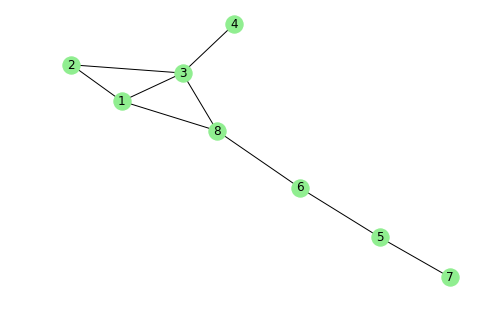

New adj_list is: [[8, 1, 3, 6], [4, 3], [5, 6, 7], [1, 8, 2, 3], [6, 8, 5], [2, 1, 3], [7, 5], [3, 1, 2, 4, 8]]
ROUND 2 STARTED! 

Iteration 1 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 seconds ( 0.0 mins ).
 Now iteration 1 finished!
Iteration 1 finished. There are 18 / 26 active tuples left. 

Iteration 2 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 seconds ( 0.0 mins ).
 Now iteration 2 finished!
Iteration 2 finished. There are 30 / 56 active tuples left. 

Iteration 3 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0

Stage4 output is:
(8, [8, 0, 'a', 1, [], [1, 3]])
(4, [4, 0, 'a', 1, [], [3]])
(5, [5, 0, 'a', 1, [], [6, 7]])
(1, [1, 0, 'a', 1, [], [8, 2, 3]])
(6, [6, 0, 'a', 1, [], [5]])
(2, [2, 0, 'a', 1, [], [1, 3]])
(7, [7, 0, 'a', 1, [], [5]])
(3, [3, 0, 'a', 1, [], [1, 2, 4, 8]])


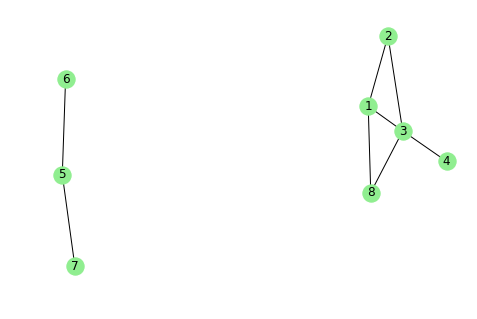

New adj_list is: [[8, 1, 3], [4, 3], [5, 6, 7], [1, 8, 2, 3], [6, 5], [2, 1, 3], [7, 5], [3, 1, 2, 4, 8]]
ROUND 3 STARTED! 

Iteration 1 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 seconds ( 0.0 mins ).
 Now iteration 1 finished!
Iteration 1 finished. There are 16 / 24 active tuples left. 

Iteration 2 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 seconds ( 0.0 mins ).
 Now iteration 2 finished!
Iteration 2 finished. There are 24 / 48 active tuples left. 

Iteration 3 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 sec

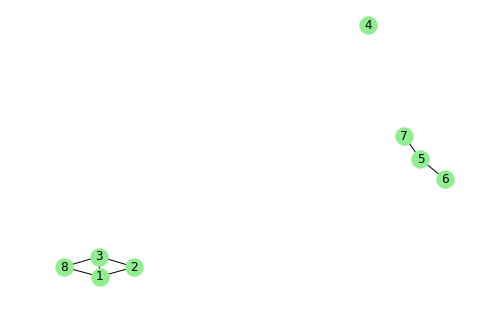

New adj_list is: [[8, 1, 3], [4], [5, 6, 7], [1, 8, 2, 3], [6, 5], [2, 1, 3], [7, 5], [3, 1, 2, 8]]
All the  3 rounds have finished. Removed edges were [[((3, 5), 10.333333333333332)], [((6, 8), 15.0)], [((3, 4), 4.0)]] . 
Please check graph figures.


In [116]:
import time

rounds=3
r=1
removed_edges=[]
print("Data contains", len(nodeId), "nodes, and", nrow, "edges (including duplicates) \n")

for i in range(rounds):
    print("ROUND", r, "STARTED! \n")
# Stage1
    t_start = time.time() 
    # Iteration until status becomes 'i' for all tuples
    act_counter = 1
    ite = 1
    while act_counter > 0:
        print("Iteration", ite, "started...")
        rdd = sc.parallelize(output)
    # <stage1 map>
        print(" Now doing Map..")
        pos_map1 = rdd.flatMap(stage1_map)
    #    test_only = pos_map1.collect()
    #    print("After Map of iteration", ite, ":")
    #    for i in range(len(test_only)):
    #        print(test_only[i])
    # <stage1 reduce>
        print(" Now doing Reduce..")
        red1_twokeys = pos_map1.map(lambda x: ((x[0],x[1][0]), x[1][1:]))
        red1_grouped = red1_twokeys.reduceByKey(join)
        red1_weighted = red1_grouped.map(stage1_reduce)
        print(" Now collecting Reduce result..")
        t1 = time.time()
        record = red1_weighted.map(twokeys_to_onekey).collect()
        t2 = time.time()
        print("  Collecting Reduce result took", round(t2-t1, 1), "seconds (", round((t2-t1)/60, 1), "mins ).")
        print(" Now flattening Reduce result..")
        t3 = time.time()
        # To flatten the grouped values (non-parallelized)
        new = []
        for i in range(len(record)):
            if type(record[i][1][1]) is list:
                record[i]
                key = record[i][0]
                srcId = [record[i][1][0]]
                others = record[i][1][1:]
                for j in range(len(others)):
                    s = srcId.copy()
                    o = others[j]
                    s.extend(o)
                    newrec = (key, s)
                    new.append(newrec)
        pos_red1 = list(filter(lambda item: type(item[1][1]) != list, record))  # Save records with only one value
        pos_red1.extend(new)  # Add records which had multiple values
        output = pos_red1.copy()
        t4 = time.time()
        print("  Flattening took", round(t4-t3, 1), "seconds (", round((t4-t3)/60, 1), "mins ).")
        print(" Now finalising Reduce result by filling in adjList..")
        # Fill in adjList before going to next iteration
        t5 = time.time()    
        for i in range(len(output)):
            if output[i][1][5] == []:
                for j in range(len(adj_list)):
                    if adj_list[j][0] == output[i][0]:
                        output[i][1][5] = adj_list[j][1:len(adj_list[j])]
                        break
        t6 = time.time()
        print("  Filling in adjList took", round(t6-t5, 1), "seconds (", round((t6-t5)/60, 1), "mins ).")
        print(" Now iteration",ite ,"finished!")
        act_counter = 0
        for i in range(len(output)):
            if output[i][1][2] == 'a':
                act_counter += 1
        print("Iteration", ite, "finished. There are", act_counter, "/", len(output), "active tuples left. \n")
        ite += 1
    stage1_output = output.copy()
    print("All the iterations have finished. Stage1 was iterated for", ite-1, "times.")
    print("Stage1 result is:")  # DELETE AFTER DEBUG
    for i in range(len(stage1_output)):  # DELETE AFTER DEBUG
        print(stage1_output[i])  # DELETE AFTER DEBUG
    t_end = time.time()
    elapsed_time = t_end-t_start
    elapsed_time_min = elapsed_time/60
    print("Total execution time was", round(elapsed_time, 1), "seconds (", round(elapsed_time_min, 1), "mins ).")

# Stage2
    pre_map2 = sc.parallelize(stage1_output)
    # Apply Map after filtering out tuples which has single node info and duplicated tuples (as we consider undirected graph network)
    pos_map2 = pre_map2.filter(lambda x: x[0] > x[1][0]).flatMap(stage2_map)
    #pos_map2.collect()
    # Stage2 Reduce
    pos_red2_directed = pos_map2.reduceByKey(add)
    # We should ignore the order of node ID at each edge and run reduceByKey(add) again
    pos_red2 = pos_red2_directed.map(lambda x: ((x[0][1], x[0][0]), x[1]) if x[0][0] > x[0][1] else x).reduceByKey(add)
    #pos_red2.collect()
# Stage3
    k_iter = 1  # We set k_iter = 1
    # Stage3 Map & Reduce
    distributed_cache = pos_red2.map(lambda x: (x[1], x[0])).sortByKey(False).map(lambda x: (x[1], x[0])).take(k_iter)
    top5 = pos_red2.map(lambda x: (x[1], x[0])).sortByKey(False).map(lambda x: (x[1], x[0])).take(5)
    print("Edge betweenness Score Top 5 is:", top5)   
    print("Round", r, "removes", distributed_cache)
    removed_edges.append(distributed_cache)
# Stage4
    pos_map4 = pre_map2.flatMap(stage4_map)
    debug = pos_map4.collect()  # DELETE AFTER DEBUG
    print("post map4 result is:")  # DELETE AFTER DEBUG
    for i in range(len(debug)):  # DELETE AFTER DEBUG
        print(debug[i])  # DELETE AFTER DEBUG
    pos_red4 = pos_map4.reduceByKey(stage4_reduce)
    output = pos_red4.collect()
    print("Stage4 output is:")  # DELETE AFTER DEBUG
    for i in range(len(output)):  # DELETE AFTER DEBUG
        print(output[i])  # DELETE AFTER DEBUG
    elist = from_tuples_to_edgelist(output)
    draw_graph(elist)
# Update adj_list    
    adj_list = []
    for i in range(len(output)):
        targ = [output[i][0]]
        targ.extend(output[i][1][5])
        adj_list.append(targ)
    print("New adj_list is:", adj_list)  # DELETE AFTER DEBUG
    r += 1

print('All the ', r-1, "rounds have finished. Removed edges were", removed_edges, ". \nPlease check graph figures.")

# 7. Result and discussion

1) Try with different datasets with different size  
2) Scale out (increase the number of computing instances)

# 8. Efficiency

1) Measure the strength of comunities (?)  
2) Try k_itr = 10 and compare executing time  
3) We can compare above result with that of non-parallelized algorithm (only if we have time)

# 9. References

1) S. Moon, et al., Parallel community detection on large graphs with MapReduce and GraphChi, Data Knowl. Eng. (2015)  
2) M.E. Newman, M. Girvan, Finding and evaluating community structure in networks, Phys. Rev. E 69 (2) (2004) 026113  
3) 

# Visualisation Part

1) Great if we can visualise large network as well  
2) There might be better way to draw a graph

These pages could be of our use:
- https://www.kaggle.com/kevinvdsk/community-detection  
- https://stackoverflow.com/questions/43541376/how-to-draw-communities-with-networkx  
- https://www.cl.cam.ac.uk/teaching/1314/L109/tutorial.pdf